# Étapes
Souligné = fait
### Gradient
<ins>Sobel</ins>, Convolution avec masque quelconque, gradient couleur, morphologique ?
### Cellules
Grid : <ins>rectangulaire</ins>, hexagonnal   
Assignation des cellules : <ins>Carte de distance</ins>, <ins>seuillage</ins>, composantes connexes
### Markers par cellules
<ins>Minima par cellules</ins>, composantes connexes -> la plus grande, cas particuliers
### Carte de distance par cellule + gradient
Distances aux markers, normalisation adaptée
### Watershed
?
### Évaluation des résultats, comparaison avec d'autres techniques

In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'img_color')

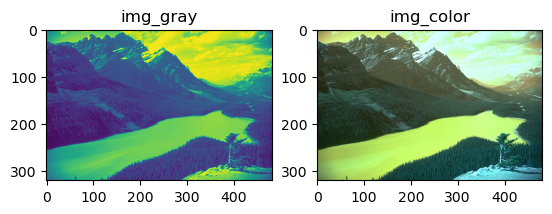

In [2]:
img_gray = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('image2.jpg')


plt.subplot(1, 2, 1)
plt.imshow(img_gray)        
plt.title("img_gray")

plt.subplot(1, 2, 2)
plt.imshow(img_color)        
plt.title("img_color")

In [3]:
noyau_x = np.array([[1, 0], [-1, 0]])
noyau_y = np.array([[1, -1], [0, 0]])

In [4]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [5]:
noyau2_x = np.array([[1, 0, 0], [0, 0, 0], [-1, 0, 0]])
noyau2_y = np.array([[1, 0, -1], [0, 0, 0], [0, 0, 0]])

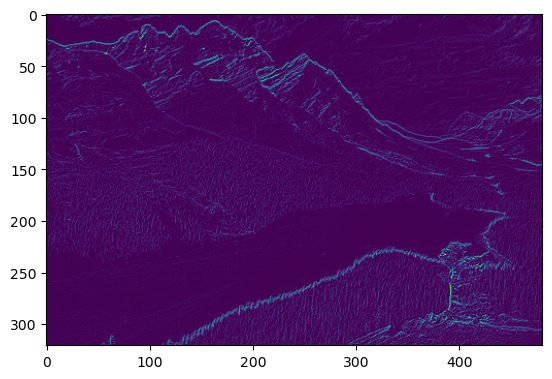

In [6]:
grad_x = cv2.filter2D(img_gray, -1, noyau_x)
grad_y = cv2.filter2D(img_gray, -1, noyau_y)

grad = np.hypot(grad_x, grad_y)
plt.imshow(grad)

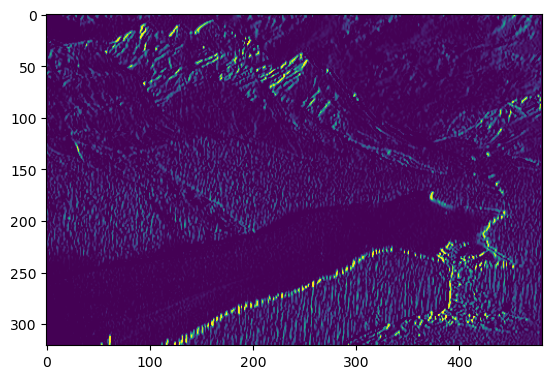

In [7]:
gradsobel_x = cv2.filter2D(img_gray, cv2.CV_8U, sobel_x)
gradsobel_y = cv2.filter2D(img_gray, cv2.CV_8U, sobel_y)

grad_sobel = np.hypot(gradsobel_x, gradsobel_y)
plt.imshow(gradsobel_x)

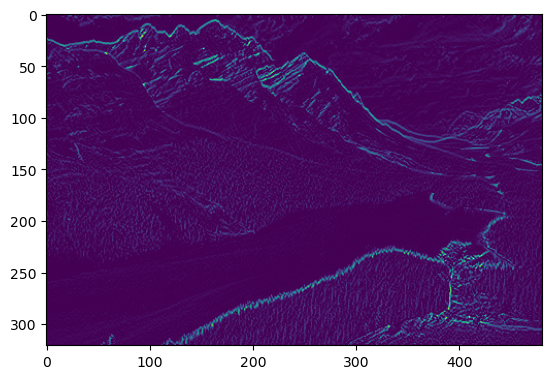

In [8]:
grad2_x = cv2.filter2D(img_gray, cv2.CV_8U, noyau2_x)
grad2_y = cv2.filter2D(img_gray, cv2.CV_8U, noyau2_y)

grad2 = np.hypot(grad2_x, grad2_y)
plt.imshow(grad2)

In [9]:
def sobel_x(img):
    n, m=img.shape
    gradx=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            gradx[i,j] = img[i-1,j+1] + 2*img[i,j+1] + img[i+1,j+1] - img[i-1,j-1] - 2*img[i,j-1] - img[i+1,j-1]
            
    return gradx
              

def sobel_y(img):
    n, m=img.shape
    grady=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            grady[i,j] = img[i-1,j-1] + 2*img[i-1,j] + img[i-1,j+1] - img[i+1,j-1] - 2*img[i+1,j] - img[i+1,j+1]
        
    return grady

def sobel(img):
    gradx, grady = sobel_x(img), sobel_y(img)
    return np.sqrt(gradx*gradx+grady*grady)

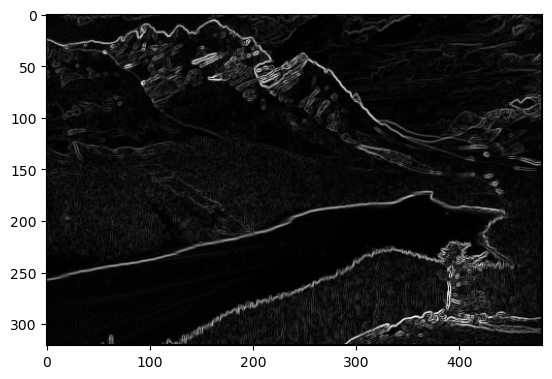

In [34]:
grad=sobel(img_gray)
grad = grad*(255/np.max(grad))
plt.imshow(grad, cmap='gray')

In [11]:
img=np.zeros((321, 481))
sigma=40

In [12]:
n, m = img.shape

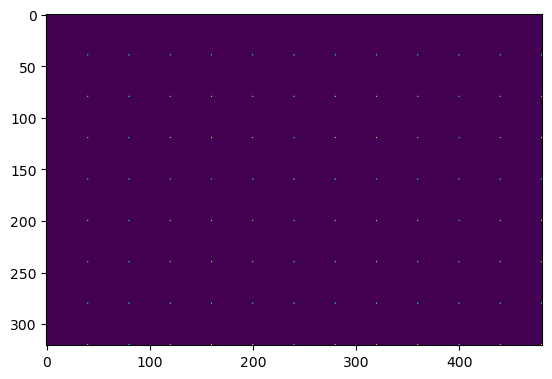

In [13]:
centers = np.zeros_like(img)
centers_coordinates = []
for i in range(0,n,sigma):
    for j in range(0,m,sigma):
        centers[i,j]=255
        centers_coordinates.append((i,j))
        
plt.imshow(img+centers)

In [14]:
def cell_centers(img, sigma, grid="square"):
    n, m = img.shape
    centers = np.zeros_like(img)
    centers_coordinates = []
    
    if grid=="square":
        for i in range(0,n,sigma):
            for j in range(0,m,sigma):
                centers[i,j]=255
                centers_coordinates.append((i,j))

    elif grid=="hexa":
        for i in range(0,n,sigma):
            if (i/sigma)%2==0:   
                for j in range(0,m,sigma*2):
                    centers[i,j]=255
            else:
                for j in range(sigma,m,sigma*2):
                    centers[i,j]=255
        
    return centers, centers_coordinates

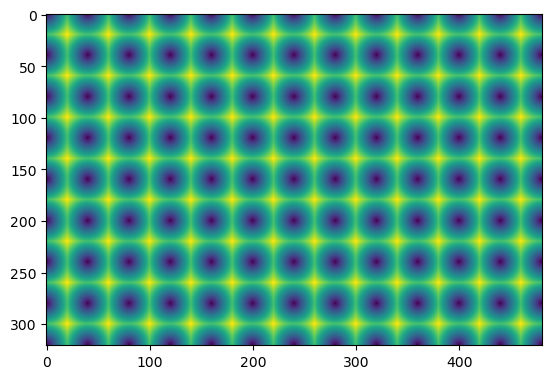

In [15]:
eucl_dist_map = np.zeros_like(img)
for i in range(n):
    for j in range(m):
        D=[]
        for c in centers_coordinates:
            (x, y)=c
            D.append(np.sqrt((x-i)**2+(y-j)**2))
        eucl_dist_map[i, j] = min(D)

plt.imshow(eucl_dist_map)

In [ ]:
demi_masque = np.ones_like(img)*np.inf
for c in centers_coordinates:
    (i, j)=c
    demi_masque[i, j]=0

masque_avant=[(-1, -1, 1), (0, -1, 1), (-1, 0, 1), (-1, 1, 1), (0, 0, 0)]

for x in range(m):
    for y in range(n):
        C=[]
        for a in masque_avant:
            i, j, v = a
            if y+j<n and x+i<m and y+j>=0 and x+i>=0:
                C.append(demi_masque[y+j, x+i]+v)      
        demi_masque[y, x] = min(C)
        
masque_arriere=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0, 1,1)]

for x in range(m-1,-1,-1):
    for y in range(n-1,-1,-1):
        C=[]
        for a in masque_arriere:
            i, j, v = a
            if y+j<n and x+i<m and y+j>=0 and x+i>=0:
                C.append(demi_masque[y+j, x+i]+v)
        demi_masque[y, x] = min(C)
        
plt.imshow(demi_masque)

In [20]:
def carte_distance(img, centers_coordinates, 
                   masque_avant=[(-2,-1,11),(-2,1,11),(-1,-2,11),(-1,-1,7),(-1,0,5),(-1,1,7),(-1,2,11),(0,-1,5),(0,0,0)],
                   masque_arriere=[(0,0,0),(0,1,5),(1,-2,11),(1,-1,7),(1,0,5),(1,1,7),(1,2,11),(2,-1,11),(2,1,11)]
                  ):
    n, m = img.shape
    carte = np.ones_like(img)*np.inf
    for center in centers_coordinates:
        (i, j)=center
        carte[i, j]=0
        
    for l in range(n):
        for c in range(m):
            C=[]
            for a in masque_avant:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)      
            carte[l, c] = min(C)

    for l in range(n-1,-1,-1):
        for c in range(m-1,-1,-1):
            C=[]
            for a in masque_arriere:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)
            carte[l, c] = min(C)
    
    return carte

Text(0.5, 1.0, 'Carte de distance 2')

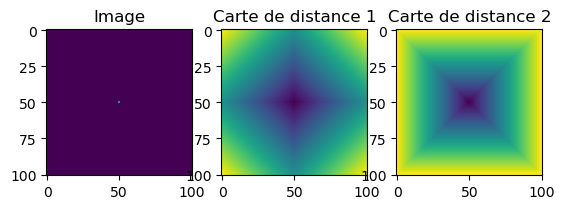

In [21]:
img=np.zeros((101,101))
centers_coordinates=[(50,50)]
for c in centers_coordinates:
    i, j=c
    img[i,j]=1

masque_avant1=[(-1, 0, 1), (0, -1, 1), (0, 0, 0)]
masque_arriere1=[(0,0,0), (1,0,1), (0, 1,1)]

masque_avant2=[(-1,-1,1), (0,-1,1), (-1,0,1), (-1,1,1), (0,0,0)]
masque_arriere2=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0,1,1)]

carte1=carte_distance(img, centers_coordinates, masque_avant1, masque_arriere1)
carte2=carte_distance(img, centers_coordinates, masque_avant2, masque_arriere2)

plt.subplot(1, 3, 1)
plt.imshow(img)        
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(carte1)        
plt.title("Carte de distance 1")

plt.subplot(1, 3, 3)
plt.imshow(carte2)        
plt.title("Carte de distance 2")

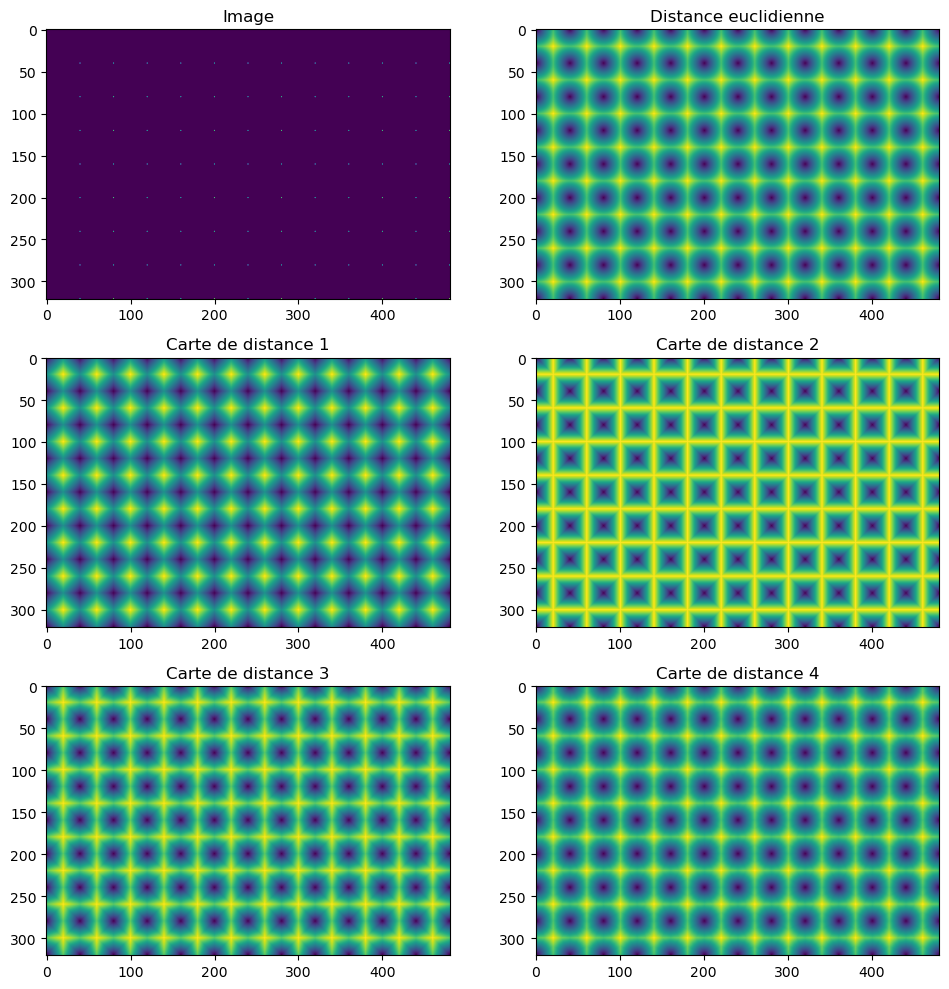

In [46]:
img=np.zeros((321, 481))
sigma=40
centers, centers_coordinates = cell_centers(img, sigma)
img=img+centers
        
masque_avant1=[(-1, 0, 1), (0, -1, 1), (0, 0, 0)]
masque_arriere1=[(0,0,0), (1,0,1), (0, 1,1)]

masque_avant2=[(-1,-1,1), (0,-1,1), (-1,0,1), (-1,1,1), (0,0,0)]
masque_arriere2=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0,1,1)]

masque_avant3=[(-1,-1,4), (0,-1,3), (-1,0,3), (-1,1,4), (0,0,0)]
masque_arriere3=[(0,0,0), (1,-1,4), (1,0,3), (1,1,4), (0,1,3)]

masque_avant4=[(-2,-1,11),(-2,1,11),(-1,-2,11),(-1,-1,7),(-1,0,5),(-1,1,7),(-1,2,11),(0,-1,5),(0,0,0)]
masque_arriere4=[(0,0,0),(0,1,5),(1,-2,11),(1,-1,7),(1,0,5),(1,1,7),(1,2,11),(2,-1,11),(2,1,11)]

carte1=carte_distance(img, centers_coordinates, masque_avant1, masque_arriere1)
carte2=carte_distance(img, centers_coordinates, masque_avant2, masque_arriere2)
carte3=carte_distance(img, centers_coordinates, masque_avant3, masque_arriere3)
carte4=carte_distance(img, centers_coordinates, masque_avant4, masque_arriere4)


plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(img)        
plt.title("Image")

plt.subplot(3, 2, 2)
plt.imshow(eucl_dist_map)        
plt.title("Distance euclidienne")

plt.subplot(3, 2, 3)
plt.imshow(carte1)        
plt.title("Carte de distance 1")

plt.subplot(3, 2, 4)
plt.imshow(carte2)        
plt.title("Carte de distance 2")

plt.subplot(3, 2, 5)
plt.imshow(carte3)        
plt.title("Carte de distance 3")

plt.subplot(3, 2, 6)
plt.imshow(carte4)        
plt.title("Carte de distance 4")

plt.tight_layout()

In [47]:
def seuillage(carte, p):
    m = np.max(carte)
    seuil = p*m
    carte_seuil = np.zeros_like(carte)
    n, m = carte.shape
    for i in range(n):
        for j in range(m):
            if carte[i, j] < seuil:
                carte_seuil[i, j]=1
            else:
                carte_seuil[i, j]=0
    return carte_seuil

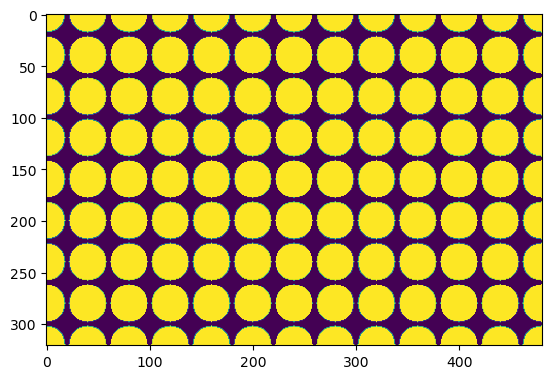

In [38]:
carte_seuil = seuillage(carte4, 0.65)
plt.imshow(carte_seuil)

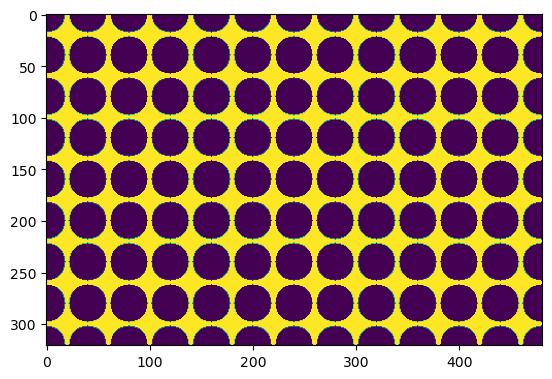

In [39]:
carte_seuil_inv = (carte_seuil+np.ones_like(carte_seuil))%2
plt.imshow(carte_seuil_inv)

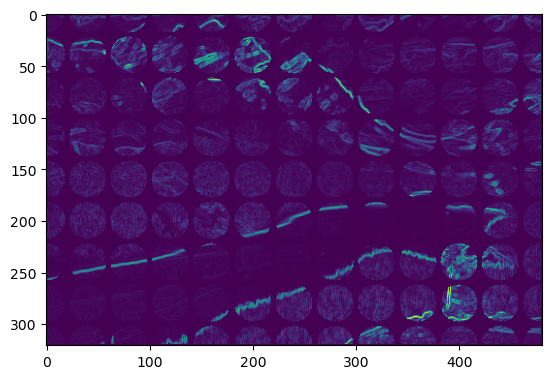

In [40]:
img_cellules=img_gray*carte_seuil
grad_cellules=grad*carte_seuil
plt.imshow(grad_cellules)

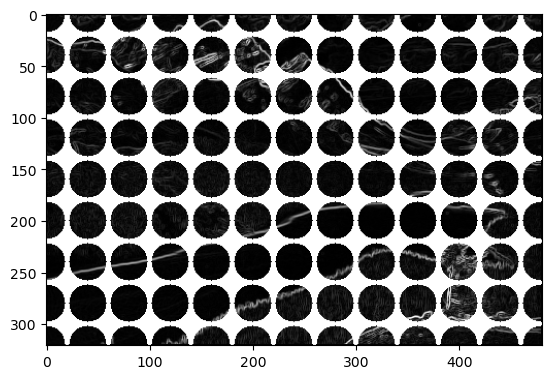

In [41]:
grad_cellules2=grad_cellules+255*carte_seuil_inv
plt.imshow(grad_cellules2, cmap='gray')

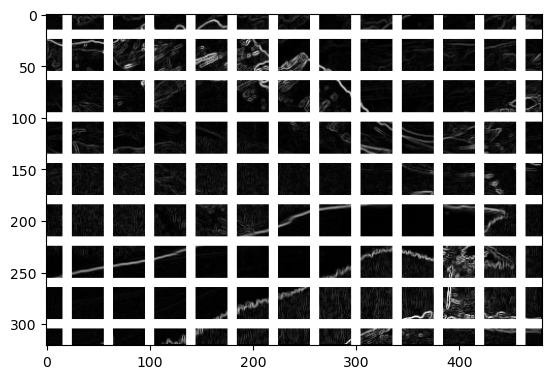

In [51]:
carte_seuil_2 = seuillage(carte2, 0.8)
carte_seuil_2_inv = (carte_seuil_2+np.ones_like(carte_seuil_2))%2

grad_cellules_carte2=grad*carte_seuil_2
grad_cellules_carte2_2=grad_cellules_carte2+255*carte_seuil_2_inv

plt.imshow(grad_cellules_carte2_2, cmap='gray')

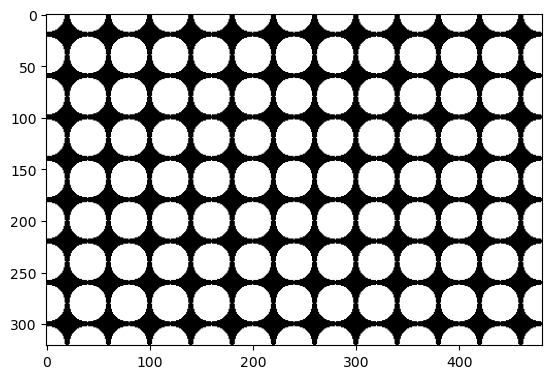

In [53]:
plt.imshow(carte_seuil, cmap='gray')

In [ ]:
def composantes_connexes(img_binaire):
    

In [54]:
def markers(cellules, grad):
    markers=[]
    for cell in cellules:
        min_grad = np.inf
        markers_in_cell=[]
        for k in range(len(cell)):
            i, j = cell[k]
            if grad[i, j]<=min_grad:
                min_grad=grad[i, j]
                markers_in_cell.append((i, j))
        markers.append(markers_in_cell)